In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

### Hyperparameters

In [2]:
test_train_ratio = 0.3

### Download and Read Data

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=74f8d56dd0a6818e7c4cb08fb4269b5711fac02f9f9229bab67ec15864e3fce7
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
import contextlib
from google.colab import files
import io

with contextlib.redirect_stdout(io.StringIO()):
    files.upload()

In [5]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

! unzip /content/fake-and-real-news-dataset.zip -d data

 81% 33.0M/41.0M [00:00<00:00, 145MB/s] 
100% 41.0M/41.0M [00:00<00:00, 143MB/s]
Archive:  /content/fake-and-real-news-dataset.zip
  inflating: data/Fake.csv           
  inflating: data/True.csv           


In [6]:
fake_data = pd.read_csv('/content/data/Fake.csv')
true_data = pd.read_csv('/content/data/True.csv')

### Data Preparation

1. Assign Label 0,1 to True and Fake datasets
2. Combine True and Fake Datasets
3. Train-Test split using stratified sampling

In [7]:
fake_data['Label'] = 1
true_data['Label'] = 0

In [15]:
data = fake_data.append(true_data)

X = data['text'].values
y = data['Label'].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=test_train_ratio)

In [24]:
print('Total no. of training examples : ', len(X_train))
print('Total no. of testing examples : ', len(X_test))

print('Label Distribution in training Data : ', Counter(y_train))
print('Label Distribution in testing Data : ', Counter(y_test))

Total no. of training examples :  31428
Total no. of testing examples :  13470
Label Distribution in training Data :  Counter({1: 16436, 0: 14992})
Label Distribution in testing Data :  Counter({1: 7045, 0: 6425})


In [26]:
# An example training datapoint
print('Example : ', X_train[0])
print('Label : ', y_train[0])

Example :  Why are banking powerhouses, European Prime Ministers, a major arms manufacturer, a representative from the US State Department, Facebook and Google all attending the same secret policy summit? One of Bilderberg s founders and steering committee member, Denis Healey said in 2001:  To say we were striving for a one-world government is exaggerated, but not wholly unfair. Those of us in Bilderberg felt we couldn t go on forever fighting one another for nothing and killing people and rendering millions homeless. So we felt that a single community throughout the world would be a good thing. From The Guardian: As one summit closes, another opens. Thursday sees the start of the influential Bilderberg policy conference, which this year is being held in Austria, just 16 miles south of the G7 summit, and in a similarly inaccessible luxury alpine resort. The participant list for the conference has just been released by the organisation, and some big names leap off the page.No fewer tha

## Experiment 1 

1. Tokenize using Count Vectorizer
2. Use Counts to create TF-IDF score for each word
3. Apply Naive Bayes Classifier

This will just be a demo to use Scikit Learn pipeline. We'd add data cleaning, feature engineering and other steps later

> `A quick note about SKLearn Pipelines` - Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit.

### Training

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Fit the pipeline on the training data
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation

In [27]:
# Run the trained pipeline on test data
predicted = text_clf.predict(X_test)
# Get the accuracy
np.mean(predicted == y_test)

0.9348923533778768

### Metrics

In classification problems, it is important to look into classification metrics like precision, recall, F1 Score.

Note the use of `ConfusionMatrixDisplay` to display Confusion Matrix in a nicer way!

Classification Report : 

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6425
           1       0.93      0.95      0.94      7045

    accuracy                           0.93     13470
   macro avg       0.94      0.93      0.93     13470
weighted avg       0.94      0.93      0.93     13470

************************************************************


Classification Confusion Matrix : 



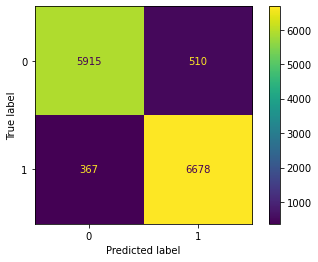

In [44]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Print the classification report
print('Classification Report : \n')
print(metrics.classification_report(y_test, predicted))
print('*'*60)
print('\nb')
# Print Confusion matrix
print('Classification Confusion Matrix : \n')
cm = confusion_matrix(y_test, predicted)
cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmd.plot();

### Inference

We can test the model on custom inputs as well. Since we are using sklearn, we need to pass the inputs as a list

In [48]:
text_clf.predict(['John Lennon was shot dead in New York'])

array([1])

In [49]:
text_clf.predict(['Donald Trump is the president of France'])

array([0])

In [50]:
text_clf.predict(['GPUs have made training the neural networks very easy!'])

array([1])

Woww! All WRONG predictions! Obviously the model is only as good as the training data and might not generalise very well on real world news, specially current, but it can be extrapolated on any set of news data

This concludes the base model for Fake news classification. Let's build other models using the same data and see if they can beat the accuracy score - 93.48%